## Часть 1. Подготовка датасета

В обучении нашей модели мы будем использовать датасет для автопилотируемых машин.

Шаг 1.

Начнем с того, что посмотрим на наш датасет. Внутри куча схожих по названию папок, каждая из которых содержит картинки. 
Но мы можем выделить в этом датасете два вида картинок. 
<br>1) Это обычные цветные картинки.
Например dataA/dataA/CameraRGB/02_00_000.png
<br>2) И есть связанные с ними картинки, разбитые на области с одинаковыми яркостями пикселей.
<br>Например dataA/dataA/CameraSeg/02_00_000.png, в ней все тоже самое, что и в первой, но  она просегментирована.

И еще заметим, что нигде в датасете нет явной информации о классах. Мы должны дать им имена сами.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

Найдем уникальные значения пискселей на картинке, и каждое такое значение будет соответствовать целому классу.

In [2]:
DATA_ROOT = '/kaggle/input/lyft-udacity-challenge/'

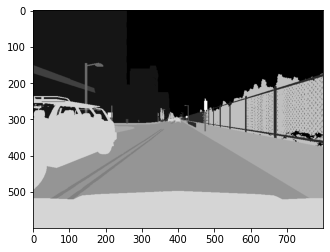

In [3]:
img = plt.imread(DATA_ROOT + 'dataA/dataA/CameraSeg/02_00_000.png')
plt.imshow(img[..., 0], cmap='gray');

In [4]:
np.unique(img * 255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

В итоге видим, что у нас 13 классов. Вы можете самостоятельно поотображать семантическую маску 
для каждого класса используя код ниже:

In [5]:
labels = ['Unlabeled','Building','Fence','Other',
          'Pedestrian', 'Pole', 'Roadline', 'Road',
          'Sidewalk', 'Vegetation', 'Car','Wall',
          'Traffic sign']

[  0 255]


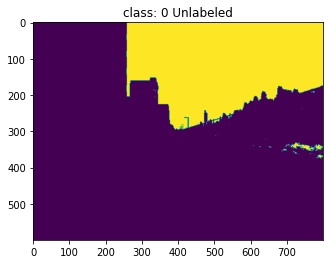

[  0 255]


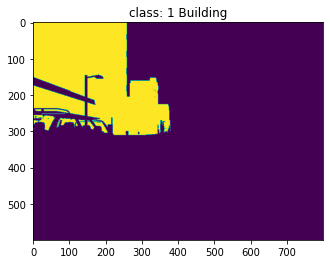

[  0 255]


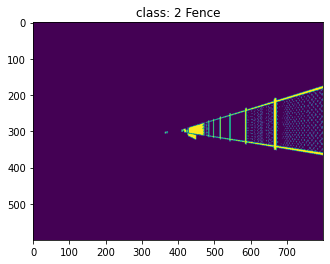

[  0 255]


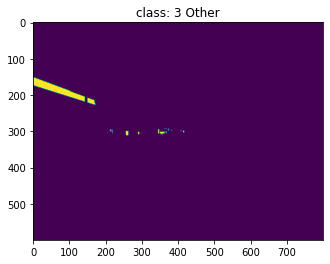

[0]


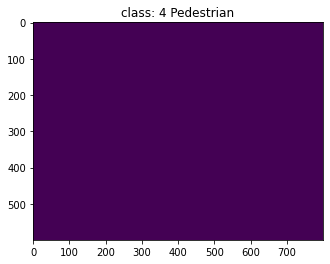

[  0 255]


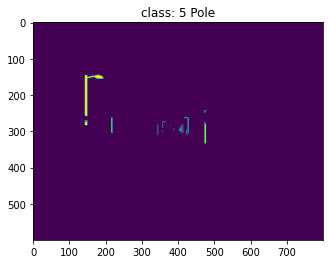

[  0 255]


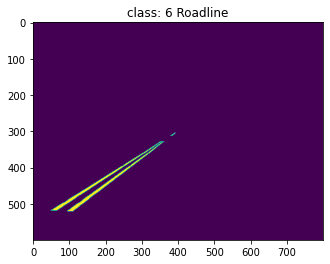

[  0 255]


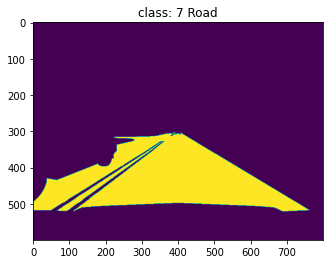

[  0 255]


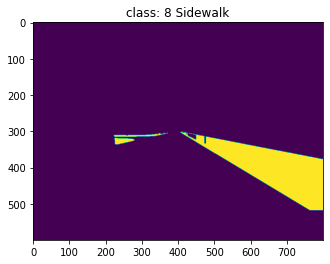

[  0 255]


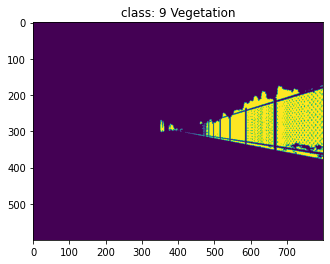

[  0 255]


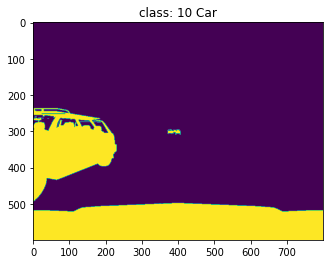

[  0 255]


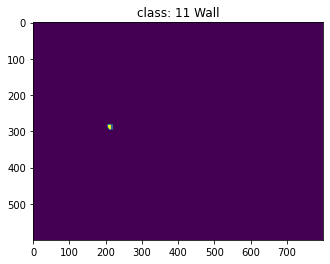

[  0 255]


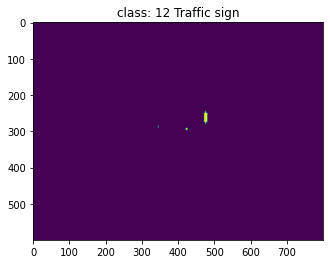

In [6]:
for i in range(13):
    mask = plt.imread(DATA_ROOT + 'dataA/dataA/CameraSeg/02_00_000.png') * 255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

Шаг 2.

Теперь приведем наш датасет к удобному виду, для этого сначала разделим все на два списка с rgb картинками и seg.

In [7]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

Теперь завернем эти два списка в DataFrame из библиотеки pandas.
В итоге выведем первые пять записей из получившегося датафрейма:

In [8]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)

df.reset_index(drop=True, inplace=True)
# Выведем первые пять значений нашего датафрейма
df.head(5)

,cameraRGB,cameraSeg
0,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
1,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
2,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
3,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
4,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...


Шаг 3. 

Теперь обернем все в кастомный датасет для удобной работы в PyTorch.

In [9]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

Создадим класс для кастомного датасета:

In [10]:
class SelfDrivingDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        masks = []
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
#         mask = Image.open(self.label_arr[index])
#         mask = mask.resize((256, 256))
#         mask = np.asarray(mask)
        
        for i in range(13):
            cls_mask = np.where(mask == i, 255, 0)
            cls_mask = cls_mask.astype('float')
            cls_mask = cv2.resize(cls_mask, (256, 256))

            masks.append(cls_mask[:,:,0] / 255)
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

torch.Size([3, 256, 256]) torch.Size([13, 256, 256])


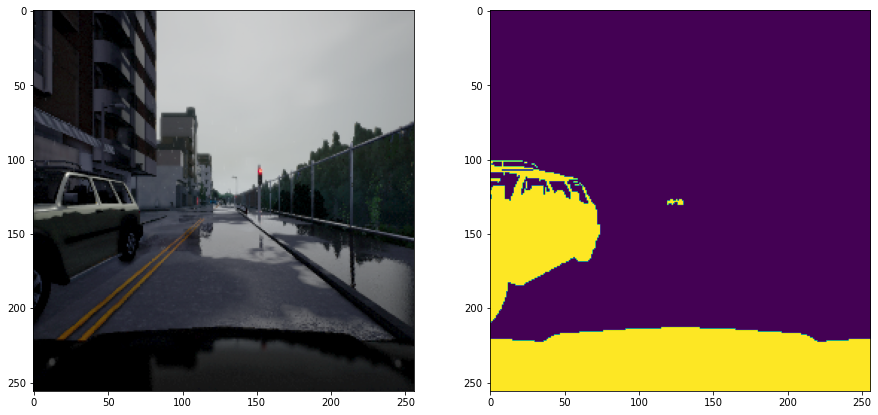

In [11]:
dataset = SelfDrivingDataset(df)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 10])
plt.show()

Затем разделим наш датасет на тренировочную и тестовую выборки.
И обернем их в наш кастомный класс.

In [12]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = SelfDrivingDataset(X_train)
test_data = SelfDrivingDataset(X_test)

И теперь уже обернем то, что получилось в известные нам в pytorch даталоадеры:

In [13]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

torch.Size([8, 3, 256, 256]) torch.Size([8, 13, 256, 256])
tensor(0.) tensor(0.7608)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


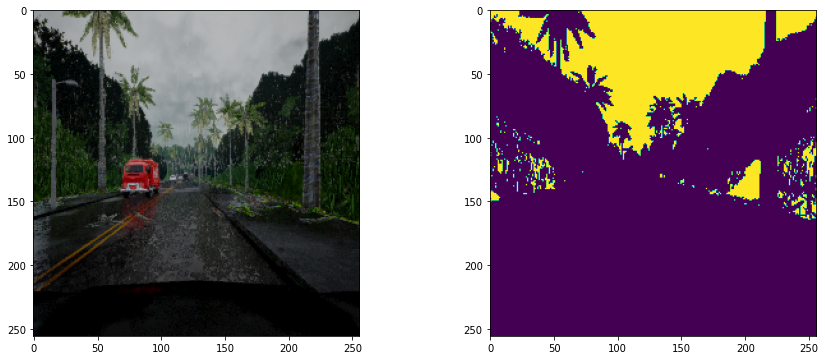

In [14]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

## Часть 2. Создание модели

Как мы отметили ранее, в архитектуре присутствует 3х3 двойной сверточный слой следующий за активационной функцией Relu в обеих частях сетки.


Шаг 1.

Создадим функцию conv_block(), параметры которой входные и выходные параметры каналов. Внутри функции последовательные сверточные слои с ядром 3 (3х3) каждый предшествует Relu активационной функции и для лучшей сходимости слои BatchNorm2d:

```
import torch
import torch.nn as nn

def conv_block(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return conv
```

Шаг 2.

Создадим класс Unet() и сделаем слои левой части и maxpool слои. В каждом слое мы используем conv_block(). Давайте назовем  слои conv_down (4 слоя в левой части): 



```
class Unet(nn.Module):
    def __init__(self, num_classes):
        super(Unet, self).__init__()
        
        self.num_classes = num_classes
        self.down_conv_11 = conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = conv_block(in_channels=512, out_channels=1024)
```



Сделаем внутри класса функцию forward(), которой мы отправим входное изображение в левую часть:


```
        def forward(self, X):
        
            x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
            x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
            x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
            x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
            x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
            x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
            x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
            x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
            middle_out = self.middle(x8) # [-1, 1024, 16, 16]
```



Вот, отлично. Мы создали левую часть нейронной сети. Осталось сделать правую часть.

Шаг 4.

Теперь давайте задекларируем 4 слоя правой части и последнюю 1х1 conv в нашей функции __init__() класса. Вместо maxpool функции мы будем использовать 2х2 transpose convolution, которая будет повышать нашу размерность:

```
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
```


Шаг 5.

Как мы видим, в архитектуре входное изображение в правой части - это комбинация изображения с левой части
и с предыдущего слоя. Но для комбинации изображений они должны быть одинаковых размеров. Поэтому давайте создадим функцию crop_tensor() для вырезания этих изображений. Внутри этой функции мы подразумеваем, что наши изображения - это тензоры.

Что происходит в функции crop_tensor() ?

tensor = изображение с левой части, которое необходимо обрезать
target tensor = изображение в правой части, которое сопоставляется с вырезанным левым изображением

Возьмем последний размер обоих тензоров target_size и tensor_size, т.к. их высота и ширина одинаковы. 
Например: x=torch.Size([1,512,64,64]), таким образом x[2] = 64

Теперь мы имея размеры обоих изображений, вычтем размер меньшего тензора из большего. Предположим
target_size = 56 и tensor_size = 64 -> delta(разница между размерами) будет 8.

Но мы ведь будем вырезать изображение из всех углов 'height' * 'width', поэтому мы разделим delta на 2. 
Таким образом, height и width могут быть вырезаны равно:
    8 => h * w=4 * 4

теперь вернем вырезанный тензор
[:,:,] = все измерения
[delta:tensor_size-delta, delta:tensor_size-delta] = вырезанное изображение

[4:64-4, 4:64-4] => 4:60, 4:60 
в примере выше нам необходима картинка 56х56

На картинке ниже показан пример вырезанной высоты:

<img src='https://drive.google.com/uc?export=view&id=1AURG8EdTu1OHHj8nxSRhEsrGqc4WNb5V' width=500>

In [15]:
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    
    return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

Шаг 6.

Теперь допишем наш forward правой части.


Комбинируем оба изображения используя torch.cat() и подставляем в up_conv():



```
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        
        return output
```



Теперь для вида запишем наши созданые ранее функции внутрь класса. В итоге наш класс Unet выглядит следующим образом:

In [16]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3,
                                            out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64,
                                            out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128,
                                            out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256,
                                            out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024,
                                          out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512,
                                          out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256,
                                          out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128,
                                          out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes,
                                kernel_size=3, stride=1,
                                padding=1)
        self.softmax = nn.Softmax()
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        output = self.softmax(output)

        return output

## Часть 3. Обучение

У нас есть готовые данные и определенная сеть, которую мы хотим обучить. Пришло время построить базовый обучающий конвейер.

Определим скорость обучения и количество эпох:

In [17]:
learning_rate = 0.001
epochs = 1

Выберем устройство,на котором будем обучать нашу модель:

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Определим нашу модель Unet для 13 классов:

In [19]:
Umodel = UNet(num_classes=13).to(device)

In [20]:
sample = (next(iter(train_data_loader)))
sample[1].shape

torch.Size([8, 13, 256, 256])

In [21]:
out = Umodel(sample[0].to(device))
out.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([8, 13, 256, 256])

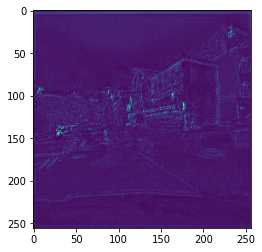

In [22]:
plt.imshow(out[0][2].detach().cpu());

Под обучением мы понимаем скармливание целевой функции оптимизирующей функции. Поэтому выберем оптимизирующую функцию и функцию потерь (целевая функция):

In [23]:
optimizer = torch.optim.Adam(Umodel.parameters())

In [24]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

Определим количество шагов внутри одной эпохи:

In [25]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 875 total_steps per epoch


In [26]:
criterion = DiceLoss()

Запускаем сам процесс обучения:

In [27]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time


# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = []
    
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = data.to(device), labels.to(device)        
        
        optimizer.zero_grad()
        outputs = Umodel(data)                
        
        #loss = nn.CrossEntropyLoss(outputs,labels)# - torch.log(DiceLoss(outputs, labels))
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx % 200 == 0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    end_time = time.time()
    print(f'Spend time for 1 epoch: {end_time - start_time} sec')
    
    epoch_losses.append(epoch_loss)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


batch index : 0 | loss : 0.9300335645675659
batch index : 200 | loss : 0.1391005516052246
batch index : 400 | loss : 0.09238719940185547
batch index : 600 | loss : 0.09342300891876221
batch index : 800 | loss : 0.08456110954284668
Epoch 1, loss:  0.12408768796920776
Spend time for 1 epoch: 2605.5179007053375 sec


Сохраним нашу модель:

In [28]:
save_model_path = './Unet_Model_dice_loss.pth'

In [29]:
torch.save(Umodel.state_dict(), save_model_path)

In [30]:
net = UNet(13).to(device)
net.load_state_dict(torch.load(save_model_path))

<All keys matched successfully>

In [31]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


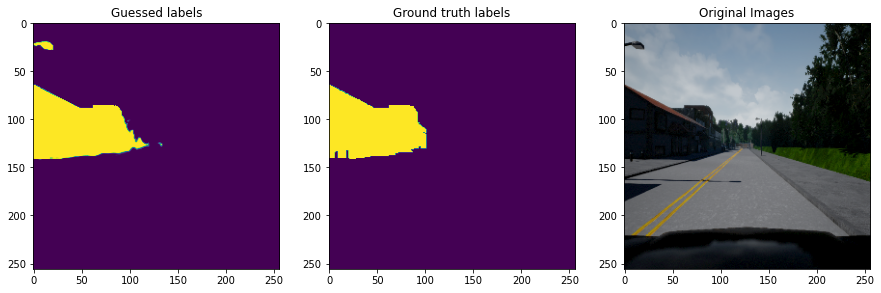

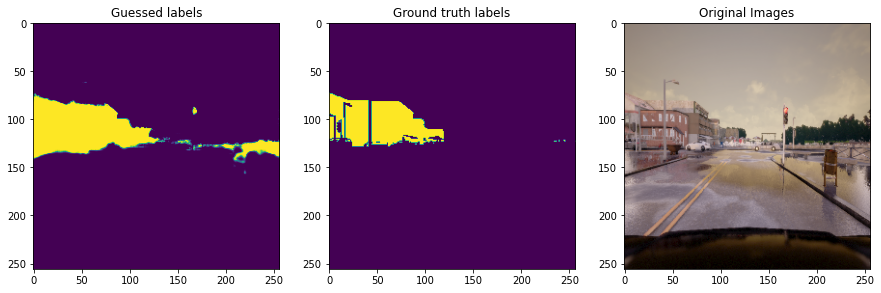

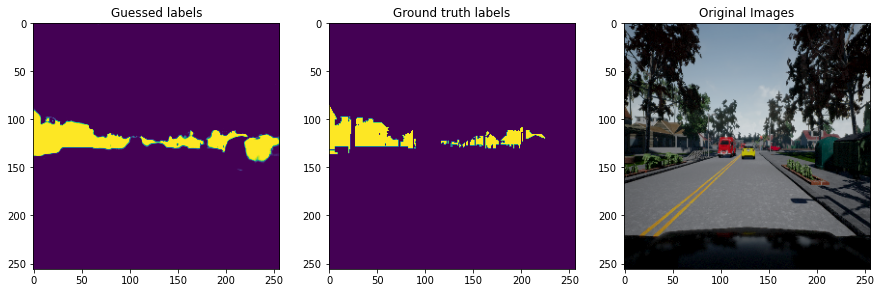

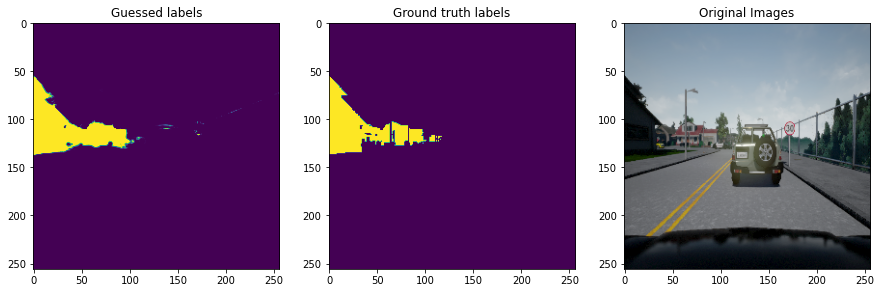

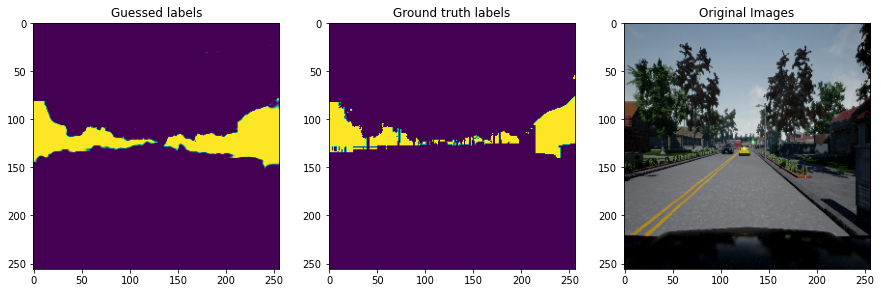

In [32]:
class_idx = 1

for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,class_idx,:,:])
        axarr[0].set_title('Guessed labels')
        axarr[1].imshow(labels.detach().cpu().numpy()[j,class_idx, :,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 3:
        break

Стоит сказать что уже есть реализация Unet в PyTorch. Она и другие популярные модели для решения задачи сегментации находятся в библиотеке [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

Если у вас нет этой библиотеки, то для дальнейшей работы вам надо ее установить через pip

In [33]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 1.0 MB/s 
     |████████████████████████████████| 58 kB 2.5 MB/s 
     |████████████████████████████████| 376 kB 4.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=e6f8a7822fd38a043928e5d7f7bc541d6bfd4d35a4d53e76a1848197f304d7ed
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=8fc80f89da2c1d0a7ddaea6180b0f98681778c0a0404f3ff96760ff93605d494
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [34]:
activation = torch.nn.Softmax(dim=1)

In [35]:
import segmentation_models_pytorch as smp

# создание модели
BACKBONE = 'resnet34'
segmodel = smp.Unet(BACKBONE, classes=13, activation='softmax2d').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

torch.Size([3, 256, 256]) torch.Size([13, 256, 256])


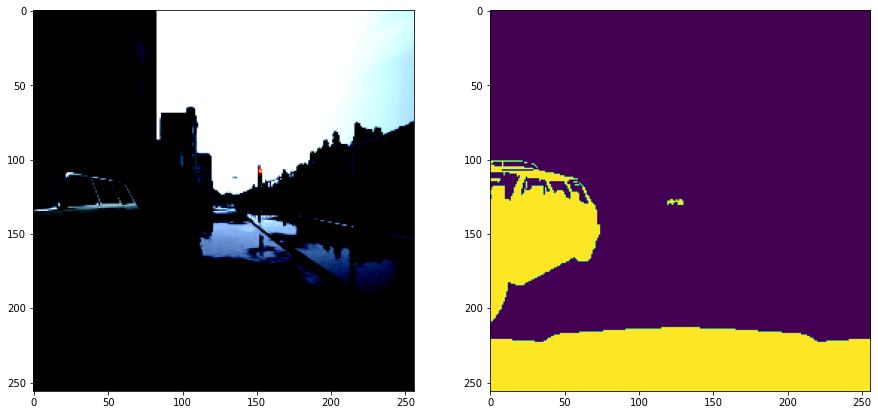

In [36]:
dataset = SelfDrivingDataset(df, preprocessing=preprocess_input)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 10])
plt.show()

In [37]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = SelfDrivingDataset(X_train,
                                preprocessing=preprocess_input)
test_data = SelfDrivingDataset(X_test,
                               preprocessing=preprocess_input)

In [38]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

In [39]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    break

torch.Size([8, 3, 256, 256]) torch.Size([8, 13, 256, 256])
tensor(-2.1179) tensor(2.0125)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


In [40]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [41]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [42]:
# train model

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 750/750 [15:46<00:00,  1.26s/it, dice_loss - 0.06967, iou_score - 0.8716]
Model saved!


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


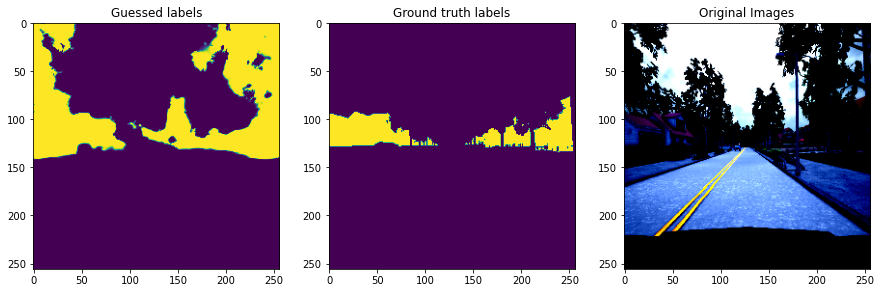

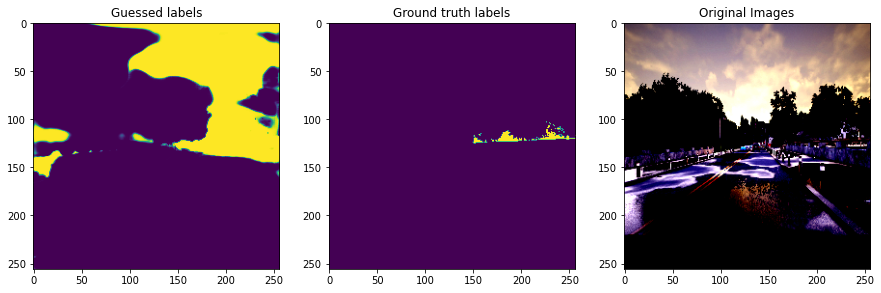

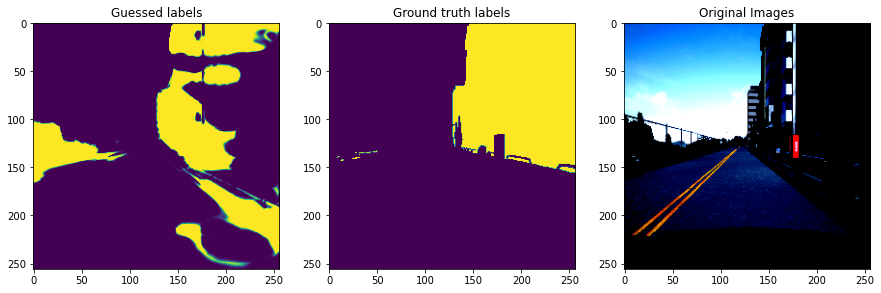

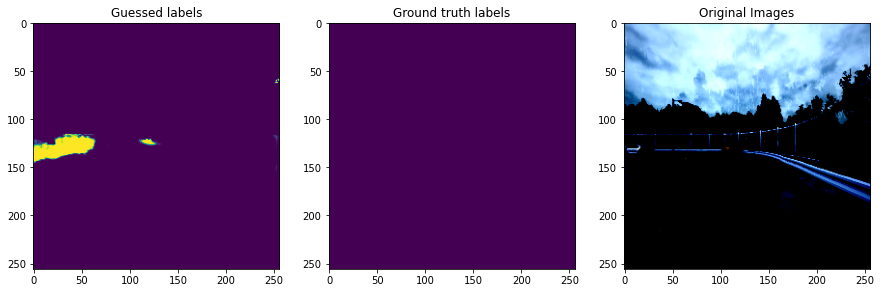

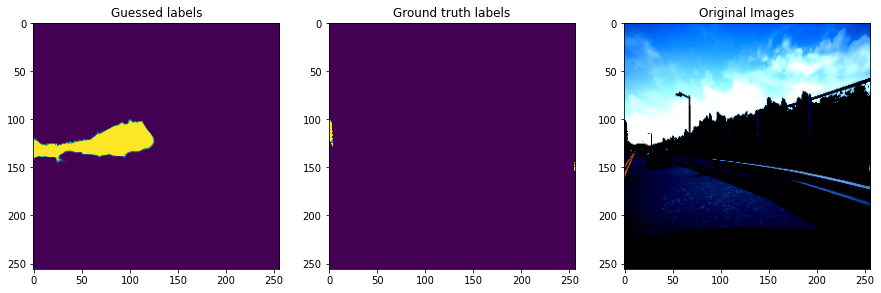

In [43]:
class_idx = 1

for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,class_idx,:,:])
        axarr[0].set_title('Guessed labels')
        axarr[1].imshow(labels.detach().cpu().numpy()[j,class_idx, :,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 3:
        break